# モジュールのインポート

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import h5py

from datetime import datetime

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# 関数、クラスの定義
モデル（ネットワークのアーキテクチャ）を変更する場合は Model クラスを書き換える。\
今は、畳み込み層2枚、全結合層2枚の単純なモデル。\
各畳み込み層の後にサイズ 2×2 の pooling 層があるため、出力サイズが半分になる点に注意して全結合層に渡している。\
畳み込み層への入力データの shape は (N,C,H,W) である（N はミニバッチサイズ、C はチャンネル数、H は画像の高さ、W は画像の幅）。\
元の画像データは (H=48,W=48)なので、Dataset クラスの最後にデータを (C=1,H=48,W=48) に reshape している(カラー画像の場合はC=3)。\
ミニバッチサイズ N のための次元は、Dataset を DataLoader に通すことで自動的に付与される。

In [2]:


def training(n_epochs,model,device,optimizer,loss_func,dataloader): 
    n_batches = len(dataloader)     # not batch size but (# of all data) / (batch_size)
    params = [p.numel() for p in model.parameters()]
    
    print()
    print(f"device        : {device}")
    print(f"learning_rate : {optimizer.defaults['lr']}")
    print(f"# of epochs   : {n_epochs}")
    print(f"batch size    : {dataloader.batch_size}")
    print(f"# of batches  : {n_batches}")
    print(f"# of params   : {sum(params)}")
    print()
    
    for i in range(0,len(params),2):
        n_para = params[i]+params[i+1]
        print(f"{n_para:>8}  ( = {params[i]} + {params[i+1]} )")
        
    print()
    print(f"--- Training start ---")
    time0 = datetime.now()
    time1 = datetime.now()
    print(time0)
    
    losss = []
    model.to(device)
    model.train()
    for epoch in range(1,n_epochs+1):
        loss_sum = 0.
        
        for x,t in dataloader:
            x = x.to(device)
            t = t.to(device)
            y = model(x)
            loss = loss_func(y,t)
            loss_sum += loss.item()
            
            optimizer.zero_grad() # grad initialization, set dJ/dw = 0
            loss.backward()       # calculate dJ/dw
            optimizer.step()      # update weight, w = w - lr * dJ/dw
            
        time2 = datetime.now()
        print(f"Epoch: {epoch:>3}/{n_epochs},    " \
              f"Loss: {loss_sum/n_batches:8.4f},    " \
              f"( {(time2-time1).total_seconds()} [s] )")
        time1 = time2
        
        losss.append(loss_sum/n_batches)
    print(f"elapsed time: {(datetime.now()-time0).total_seconds()} [s]")
    print("--- Training finished ---")
    print()
    return losss
    


class Model(nn.Module):
    def __init__(self):
        super().__init__()
        # L_out = (L_in + 2P - K)//S + 1
        self.conv1 = nn.Conv2d(1,32,kernel_size=5,stride=5,padding=1) 
        self.bn1   = nn.BatchNorm2d(num_features=32)
        
        self.conv2 = nn.Conv2d(32,32,kernel_size=3,stride=1,padding=1) 
        self.bn2   = nn.BatchNorm2d(num_features=32)
        
        self.aff1  = nn.Linear(32*8*8,32)
        self.aff2  = nn.Linear(32,2)
        
        self.lsm   = nn.LogSoftmax(dim=1)
        

    def forward(self,z):
        z = self.conv1(z)       
        z = self.bn1(z)         
        z = torch.relu(z)
        z = F.max_pool2d(z,kernel_size=2,stride=1) # (H/2,W/2)
       
        z = self.conv2(z)
        z = self.bn2(z) 
        z = torch.relu(z)
        z = F.max_pool2d(z,kernel_size=2,stride=1) # (H/4,W/4)

        #print(f"z shape: {z.shape}")
             
        z = z.view(-1,32*8*8)  
        z = self.aff1(z)
        z = torch.relu(z)
        z = self.aff2(z)
        z = self.lsm(z)
        
        return z



#class LossFunc(nn.Module):
#    # in Pytorch,
#    #    LogSoftmax(logit)  +  NLLLoss(class label 1D tensor) 
#    #  =           (logit)  +  CrossEntropyLoss(class label 1D tensor, or "float" type one-hot tensor)
#    #  =    Softmax(logit)  +  a common cross_entropy_loss(one-hot tensor)
#    def __init__(self): 
#        super(LossFunc,self).__init__()
#
#    def forward(self,y,t):
#        return cross_entropy_loss(y,t)

#def cross_entropy_loss(y,t):
#    return -torch.mean(torch.sum(t*torch.log(y),dim=1))



class Dataset(torch.utils.data.Dataset):
    def __init__(self,path,mode):
        if mode == "training": path += "tra"
        elif mode == "test"  : path += "tes"
        self.file0 =  path + "_neg.h5"
        self.file1 =  path + "_pos.h5"

        with h5py.File(self.file0,"r") as fi:
            self.n0 = len(fi.keys())
        with h5py.File(self.file1,"r") as fi:
            self.n1 = len(fi.keys())

    def __len__(self):
        return self.n0 + self.n1

    def __getitem__(self, idx):
        if idx < self.n0:
            file = self.file0
        else:
            file = self.file1
            idx -= self.n0
            
        with h5py.File(file,"r") as fi:
            ds = fi[f"{idx:06}"]
            x = ds[:]
            t = ds.attrs["t"]
        return x.reshape(1,48,48),t



# 各種設定

・data_path を自分のPC内の hdf5 ファイルがある場所に変更する。

・Windows の場合はGPUの設定を、\
device = torch.device("cuda") if torch.backends.cuda.is_available() else torch.device("cpu") \
とする。

39861
t: 0


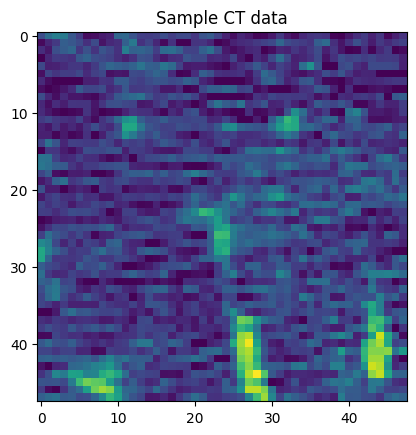

In [4]:

# === Data set ===
data_path = "/Users/fujii/Works/Pytorch/CT/data_hdf5/"
tra_ds = Dataset(data_path,mode="training")
print(len(tra_ds))


print(f"t: {tra_ds[19988][1]}")
plt.imshow(tra_ds[19988][0][0])
plt.title("Sample CT data")
plt.show()


# === Loss function ===
loss_func = nn.NLLLoss()
#loss_func = nn.CrossEntropyLoss()
#loss_func = LossFunc()


# === Device ===
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu") # for Mac
#device = torch.device("cuda") if torch.backends.cuda.is_available() else torch.device("cpu") # for Windows
#device = torch.device("cpu")


# === Model ===
model = Model()
#print(model)


# === Optimizer ===
optimizer = optim.SGD(model.parameters(),lr=0.001) 
#optimizer = optim.Adam(model.parameters(),lr=1e-3)


loss_lis = []

# 学習
おそらく10エポックで1分位かかる。\
GPU（cuda）を使える場合は少し早くなる。\
ミニバッチサイズ batch_size を増やしても計算速度は早くなるが、収束性が悪くなる可能性がある。\
スコア（loss）が十分収束しなかった場合、下のセルを再び実行すると続きから学習が可能。\
（一つ上のセルを実行してしまうと、model と optimizer が初期化されて最初からの学習になってしまう）


device        : mps
learning_rate : 0.001
# of epochs   : 10
batch size    : 50
# of batches  : 798
# of params   : 75842

     832  ( = 800 + 32 )
      64  ( = 32 + 32 )
    9248  ( = 9216 + 32 )
      64  ( = 32 + 32 )
   65568  ( = 65536 + 32 )
      66  ( = 64 + 2 )

--- Training start ---
2024-02-09 09:01:38.243902
Epoch:   1/10,    Loss:   0.2008,    ( 8.270263 [s] )
Epoch:   2/10,    Loss:   0.1977,    ( 8.270788 [s] )
Epoch:   3/10,    Loss:   0.1941,    ( 8.279292 [s] )
Epoch:   4/10,    Loss:   0.1926,    ( 8.286019 [s] )
Epoch:   5/10,    Loss:   0.1892,    ( 8.277347 [s] )
Epoch:   6/10,    Loss:   0.1867,    ( 8.315069 [s] )
Epoch:   7/10,    Loss:   0.1838,    ( 8.305993 [s] )
Epoch:   8/10,    Loss:   0.1820,    ( 8.29501 [s] )
Epoch:   9/10,    Loss:   0.1796,    ( 8.326303 [s] )
Epoch:  10/10,    Loss:   0.1763,    ( 8.289807 [s] )
elapsed time: 82.915976 [s]
--- Training finished ---

Training Loss: 0.17629119993320533


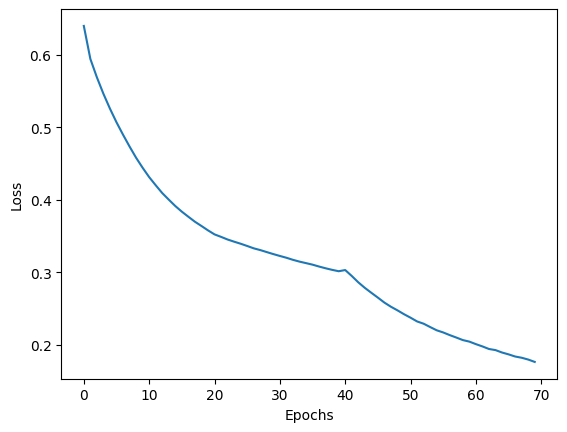

In [12]:
# --- Hyper parameters ---
learning_rate = 0.001  # default 0.001
n_epochs      = 10
batch_size    = 50
# ------------------------

tra_dl = torch.utils.data.DataLoader(tra_ds,batch_size=batch_size,shuffle=True)        
optimizer.defaults["lr"] = learning_rate


losss = training(
    n_epochs   = n_epochs,
    model      = model,
    device     = device,
    optimizer  = optimizer,
    loss_func  = loss_func,
    dataloader = tra_dl,
)

print(f"Training Loss: {losss[-1]}")
loss_lis.extend(losss)


plt.plot(loss_lis)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()


# If you want to continue learning, just run this cell
# (the parameters of model and optimizer will be inherited).

# 検証
pp: 正解ラベルが t=1（陽性）で、予測値 y が閾値（threshold）より大きい\
pn: 正解ラベルが t=1（陽性）で、予測値 y が閾値より小さい\
np: 正解ラベルが t=0（陰性）で、予測値 y が閾値より大きい\
nn: 正解ラベルが t=0（陰性）で、予測値 y が閾値より小さい\

pp と nn は、正しく予測出来たということ。\
pn は、本当は陽性なのに、それを見逃して陰性と判断してしまったということで、これはあってはならない間違いである。\
np は、陰性の人を陽性と判断してしまったということで、これは別に問題ない。\
（このモデルを使ってやりたいことは、専門家がCT画像を解析する前に少しでも疑わしい箇所を自動的に検出しておき、専門家の判断の負担を減らすことである。最終的には専門家が判断するので、np が多くてもあまり問題はない。）\

Accuracy は正答率のことで、陽性サンプルに対しては、ppの数 / (ppの数 + pnの数)、陰性サンプルに対しては nnの数 / (npの数 + nnの数)である。




In [17]:

def cross_entropy_error(y,t):
    return -np.sum( t*np.log(y+1e-7) )



tes_ds = Dataset(data_path,mode="test")
n_tes = len(tes_ds)


#thr = 0.5  # threshold value
thr = 0.3
cnt = {"pp":0,"pn":0,"np":0,"nn":0,}   # counters
samples = {"pp":[],"pn":[],"np":[],"nn":[],}

loss_sum = 0

model.eval()
with torch.no_grad():
    for i in range(n_tes):
        x,t = tes_ds[i]
        x = x.reshape(1,1,48,48)
        x = torch.from_numpy(x).to(device)
        
        y = model(x)
        
        y = y.cpu()        # GPU (mps or cuda) -> CPU
        y = y.numpy()      # torch tensor -> numpy array
        y = np.exp(y[0])   # LogSoftmax -> Softmax
        
        t_oh = [0,0]
        t_oh[t] = 1
        
        loss = cross_entropy_error(y,t_oh)
        loss_sum += loss
        #print(i,y,t,loss)

        if t == 1:
            if y[1] >= thr:
                key = "pp"
            else:
                key = "pn"
        else:
            if y[1] >= thr:
                key = "np"
            else:
                key = "nn"
                
        cnt[key] += 1
        samples[key].append((x.cpu().numpy()[0][0],t,y[1]))



print(f"Test loss: {loss_sum/n_tes}")
print()

print(f"Threshold: {thr}")
print(f"cnt_pp (t=1, y>={thr}) : {cnt['pp']}")
print(f"cnt_pn (t=1, y<{thr})  : {cnt['pn']}")
print(f"cnt_np (t=0, y>={thr}) : {cnt['np']}")
print(f"cnt_nn (t=0, y<{thr})  : {cnt['nn']}")
print()

print(f"Accuracy for positive samples : {cnt['pp']/200*100} [%]  ( {cnt['pn']/200*100} [%] )")
print(f"Accuracy for negative samples : {cnt['nn']/200*100} [%]  ( {cnt['np']/200*100} [%] )")
print(f"Accuracy for all samples      : {(cnt['pp']+cnt['nn'])/400*100} [%]")



Test loss: 0.2563545800262796

Threshold: 0.3
cnt_pp (t=1, y>=0.3) : 194
cnt_pn (t=1, y<0.3)  : 6
cnt_np (t=0, y>=0.3) : 54
cnt_nn (t=0, y<0.3)  : 146

Accuracy for positive samples : 97.0 [%]  ( 3.0 [%] )
Accuracy for negative samples : 73.0 [%]  ( 27.0 [%] )
Accuracy for all samples      : 85.0 [%]


# 誤判断された画像の確認
label="pn" とすると pn サンプル、つまり陽性を陰性と誤判断してしまったサンプルの画像を確認できる。

pn samples: 6
0  t:1, y:0.2155447155237198


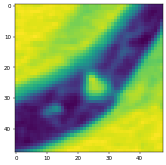

1  t:1, y:0.16473357379436493


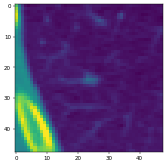

2  t:1, y:0.013746512122452259


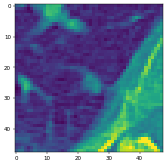

3  t:1, y:0.15904028713703156


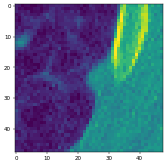

4  t:1, y:0.13039351999759674


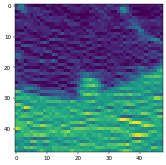

5  t:1, y:0.18412593007087708


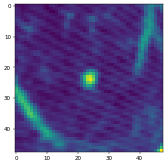

In [16]:
label = "pn" 

print(f"{label} samples: {len(samples[label])}")
for i,(x,t,y) in enumerate(samples[label]):
    print(f"{i}  t:{t}, y:{y}")
    fig = plt.figure(dpi=40)
    plt.imshow(x)
    #plt.title(f"t:{t}, y:{y}")
    plt.show()